In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Adam = optimizers.Adam(lr=0.001)

In [2]:
csv_path_train = 'testset/J0003_0024_0221_20110307012732_cell_9.csv'
csv_path_test = 'testset/J0003_0024_0221_20110307012732_cell_03.csv'
df = pd.read_csv(csv_path_train)
df_test = pd.read_csv(csv_path_test)

date_time = pd.to_datetime(df.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')
date_time_test = pd.to_datetime(df_test.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')

In [3]:
df.head()

,CellNo,Resistance,Volt,Temp
0,9,0.193,2.25,-20
1,9,0.193,2.24,-20
2,9,0.194,2.25,-20
3,9,0.193,2.24,-20
4,9,0.194,2.25,-20


In [4]:
df_test.head()

,CellNo,Resistance,Volt,Temp
0,3,0.298,2.23,-20
1,3,0.298,2.23,-20
2,3,0.297,2.24,-20
3,3,0.299,2.23,-20
4,3,0.298,2.24,-20


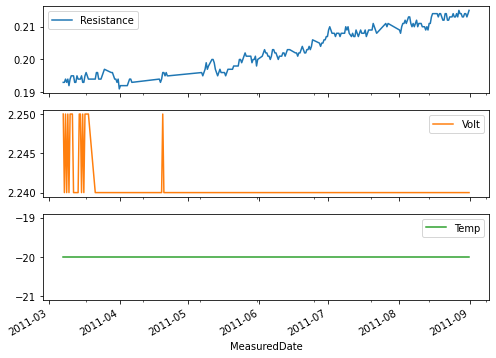

In [5]:
plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


array([<AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>], dtype=object)

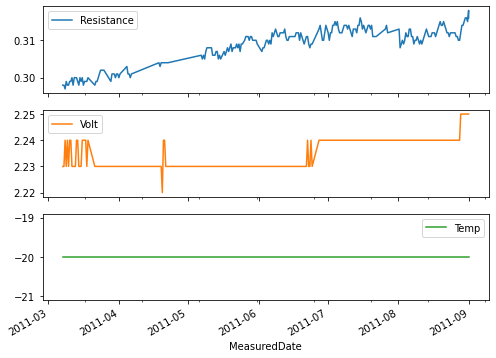

In [6]:
#plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features_test = df_test[plot_cols]
plot_features_test.index = date_time_test
plot_features_test.plot(subplots=True)

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CellNo,254.0,9.000000,0.000000,9.000,9.000,9.000,9.00,9.000
Resistance,254.0,0.203417,0.006978,0.191,0.197,0.203,0.21,0.215
Volt,254.0,2.240551,0.002287,2.240,2.240,2.240,2.24,2.250
Temp,254.0,-20.000000,0.000000,-20.000,-20.000,-20.000,-20.00,-20.000


In [8]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices = {name: i for i, name in enumerate(df_test.columns)}

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
df = scaler.fit_transform(df[plot_cols])
df_test = scaler.fit_transform(df_test[plot_cols])
df = pd.DataFrame(df)
df_test = pd.DataFrame(df_test)
df.columns = plot_cols
df_test.columns = plot_cols

In [10]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.8)]
test_df = df[int(n*0.8):]
#n_test = len(df_test)
test_df_test = df_test[:int(n*0.7)]
label_df = df_test[int(n*0.7):]

num_features = df.shape[1]
#print(int(n*0.8),int(n*0.2),len(test_df), len(label_df))

In [11]:
df.head()

,Resistance,Volt,Temp
0,0.083333,1.0,0.0
1,0.083333,0.0,0.0
2,0.125000,1.0,0.0
3,0.083333,0.0,0.0
4,0.125000,1.0,0.0


<AxesSubplot:>

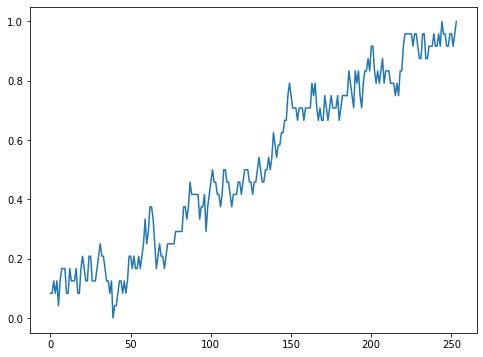

In [12]:
df['Resistance'].plot()

In [13]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

    # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [14]:
#w1 = WindowGenerator(input_width = 28, label_width=28, shift=1, label_columns = ['Resistance'])
#w1

In [15]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
def plot(self, model=None, plot_col='Resistance', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    max_n=1
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.plot(self.label_indices, labels[n, :, label_col_index], label='Labels', c='#2ca02c', zorder=-10)
                #edgecolors='k', c='#2ca02c', s=1)
        if model is not None:
            predictions = model(inputs)
            plt.plot(self.label_indices, predictions[n, :, label_col_index], label='Predictions', c='#ff7f0e', zorder=-10)
                   
             #           edgecolors='k', label='Predictions',
              #    c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [17]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets = None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

In [18]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

def test_test(self):
    return self.make_dataset(self.test_df_test)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
    # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.test_test = test_test

Total window size: 174
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]
Label indices: [150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173]
Label column name(s): None

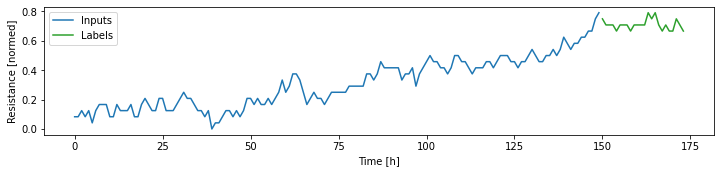

In [19]:
OUT_STEPS = 24

multi_window = WindowGenerator(input_width=150,
                              label_width=OUT_STEPS,
                              shift=OUT_STEPS)

multi_window.plot()
multi_window

In [20]:
MAX_EPOCHS = 1500

def compile_and_fit(model, window, patience=500):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                    # optimizer=tf.optimizers.Adam(),
                    optimizer=Adam,
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [21]:
model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # tf.keras.layers.LSTM(32, activation='relu', kernel_initializer='he_normal', dropout=0.1, return_sequences=False),
    # tf.keras.layers.Dropout(rate=0.2),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [22]:
history = compile_and_fit(model, multi_window)

Epoch 1/1500
1/1 [==============================] - 5s 5s/step - loss: 0.1683 - mean_absolute_error: 0.2365
Epoch 2/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.1667 - mean_absolute_error: 0.2355
Epoch 3/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.1651 - mean_absolute_error: 0.2343
Epoch 4/1500
1/1 [==============================] - 0s 106ms/step - loss: 0.1633 - mean_absolute_error: 0.2330
Epoch 5/1500
1/1 [==============================] - 0s 175ms/step - loss: 0.1614 - mean_absolute_error: 0.2317
Epoch 6/1500
1/1 [==============================] - 0s 137ms/step - loss: 0.1593 - mean_absolute_error: 0.2302
Epoch 7/1500
1/1 [==============================] - 0s 114ms/step - loss: 0.1571 - mean_absolute_error: 0.2285
Epoch 8/1500
1/1 [==============================] - 0s 103ms/step - loss: 0.1546 - mean_absolute_error: 0.2267
Epoch 9/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.1518 - mean_absolute_error: 0.2246
Epoch 1

Epoch 34/1500
1/1 [==============================] - 0s 98ms/step - loss: 3.9303e-04 - mean_absolute_error: 0.0091
Epoch 35/1500
1/1 [==============================] - 0s 101ms/step - loss: 7.6634e-04 - mean_absolute_error: 0.0142
Epoch 36/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0015 - mean_absolute_error: 0.0202
Epoch 37/1500
1/1 [==============================] - 0s 95ms/step - loss: 0.0023 - mean_absolute_error: 0.0257
Epoch 38/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0032 - mean_absolute_error: 0.0308
Epoch 39/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0039 - mean_absolute_error: 0.0347
Epoch 40/1500
1/1 [==============================] - 0s 102ms/step - loss: 0.0045 - mean_absolute_error: 0.0372
Epoch 41/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0048 - mean_absolute_error: 0.0386
Epoch 42/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.0048 - mean_absolute_erro

Epoch 67/1500
1/1 [==============================] - 0s 102ms/step - loss: 6.3576e-04 - mean_absolute_error: 0.0120
Epoch 68/1500
1/1 [==============================] - 0s 99ms/step - loss: 5.8505e-04 - mean_absolute_error: 0.0114
Epoch 69/1500
1/1 [==============================] - 0s 112ms/step - loss: 5.2954e-04 - mean_absolute_error: 0.0108
Epoch 70/1500
1/1 [==============================] - 0s 102ms/step - loss: 4.7334e-04 - mean_absolute_error: 0.0102
Epoch 71/1500
1/1 [==============================] - 0s 108ms/step - loss: 4.2004e-04 - mean_absolute_error: 0.0096
Epoch 72/1500
1/1 [==============================] - 0s 103ms/step - loss: 3.7256e-04 - mean_absolute_error: 0.0091
Epoch 73/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.3297e-04 - mean_absolute_error: 0.0086
Epoch 74/1500
1/1 [==============================] - 0s 101ms/step - loss: 3.0244e-04 - mean_absolute_error: 0.0082
Epoch 75/1500
1/1 [==============================] - 0s 110ms/step - loss

Epoch 99/1500
1/1 [==============================] - 0s 96ms/step - loss: 2.6493e-04 - mean_absolute_error: 0.0076
Epoch 100/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6621e-04 - mean_absolute_error: 0.0076
Epoch 101/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6760e-04 - mean_absolute_error: 0.0077
Epoch 102/1500
1/1 [==============================] - 0s 97ms/step - loss: 2.6888e-04 - mean_absolute_error: 0.0077
Epoch 103/1500
1/1 [==============================] - 0s 96ms/step - loss: 2.6988e-04 - mean_absolute_error: 0.0077
Epoch 104/1500
1/1 [==============================] - 0s 97ms/step - loss: 2.7050e-04 - mean_absolute_error: 0.0078
Epoch 105/1500
1/1 [==============================] - 0s 98ms/step - loss: 2.7070e-04 - mean_absolute_error: 0.0078
Epoch 106/1500
1/1 [==============================] - 0s 123ms/step - loss: 2.7050e-04 - mean_absolute_error: 0.0078
Epoch 107/1500
1/1 [==============================] - 0s 96ms/step - l

1/1 [==============================] - 0s 105ms/step - loss: 2.6389e-04 - mean_absolute_error: 0.0075
Epoch 132/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6380e-04 - mean_absolute_error: 0.0074
Epoch 133/1500
1/1 [==============================] - 0s 96ms/step - loss: 2.6375e-04 - mean_absolute_error: 0.0074
Epoch 134/1500
1/1 [==============================] - 0s 104ms/step - loss: 2.6373e-04 - mean_absolute_error: 0.0074
Epoch 135/1500
1/1 [==============================] - 0s 97ms/step - loss: 2.6373e-04 - mean_absolute_error: 0.0075
Epoch 136/1500
1/1 [==============================] - 0s 101ms/step - loss: 2.6375e-04 - mean_absolute_error: 0.0075
Epoch 137/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6378e-04 - mean_absolute_error: 0.0075
Epoch 138/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6381e-04 - mean_absolute_error: 0.0075
Epoch 139/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6384

1/1 [==============================] - 0s 101ms/step - loss: 2.6373e-04 - mean_absolute_error: 0.0075
Epoch 164/1500
1/1 [==============================] - 0s 97ms/step - loss: 2.6373e-04 - mean_absolute_error: 0.0075
Epoch 165/1500
1/1 [==============================] - 0s 96ms/step - loss: 2.6372e-04 - mean_absolute_error: 0.0075
Epoch 166/1500
1/1 [==============================] - 0s 105ms/step - loss: 2.6372e-04 - mean_absolute_error: 0.0075
Epoch 167/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6372e-04 - mean_absolute_error: 0.0075
Epoch 168/1500
1/1 [==============================] - 0s 104ms/step - loss: 2.6372e-04 - mean_absolute_error: 0.0075
Epoch 169/1500
1/1 [==============================] - 0s 101ms/step - loss: 2.6372e-04 - mean_absolute_error: 0.0075
Epoch 170/1500
1/1 [==============================] - 0s 94ms/step - loss: 2.6372e-04 - mean_absolute_error: 0.0075
Epoch 171/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6372e

1/1 [==============================] - 0s 104ms/step - loss: 2.6371e-04 - mean_absolute_error: 0.0075
Epoch 196/1500
1/1 [==============================] - 0s 101ms/step - loss: 2.6371e-04 - mean_absolute_error: 0.0075
Epoch 197/1500
1/1 [==============================] - 0s 113ms/step - loss: 2.6371e-04 - mean_absolute_error: 0.0075
Epoch 198/1500
1/1 [==============================] - 0s 98ms/step - loss: 2.6371e-04 - mean_absolute_error: 0.0075
Epoch 199/1500
1/1 [==============================] - 0s 106ms/step - loss: 2.6371e-04 - mean_absolute_error: 0.0075
Epoch 200/1500
1/1 [==============================] - 0s 111ms/step - loss: 2.6371e-04 - mean_absolute_error: 0.0075
Epoch 201/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6371e-04 - mean_absolute_error: 0.0075
Epoch 202/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6371e-04 - mean_absolute_error: 0.0075
Epoch 203/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6371e

1/1 [==============================] - 0s 104ms/step - loss: 2.6371e-04 - mean_absolute_error: 0.0075
Epoch 228/1500
1/1 [==============================] - 0s 108ms/step - loss: 2.6371e-04 - mean_absolute_error: 0.0075
Epoch 229/1500
1/1 [==============================] - 0s 106ms/step - loss: 2.6371e-04 - mean_absolute_error: 0.0075
Epoch 230/1500
1/1 [==============================] - 0s 112ms/step - loss: 2.6371e-04 - mean_absolute_error: 0.0075
Epoch 231/1500
1/1 [==============================] - 0s 101ms/step - loss: 2.6371e-04 - mean_absolute_error: 0.0075
Epoch 232/1500
1/1 [==============================] - 0s 92ms/step - loss: 2.6371e-04 - mean_absolute_error: 0.0075
Epoch 233/1500
1/1 [==============================] - 0s 112ms/step - loss: 2.6371e-04 - mean_absolute_error: 0.0075
Epoch 234/1500
1/1 [==============================] - 0s 141ms/step - loss: 2.6371e-04 - mean_absolute_error: 0.0075
Epoch 235/1500
1/1 [==============================] - 0s 107ms/step - loss: 2.63

Epoch 259/1500
1/1 [==============================] - 0s 113ms/step - loss: 2.6370e-04 - mean_absolute_error: 0.0075
Epoch 260/1500
1/1 [==============================] - 0s 115ms/step - loss: 2.6370e-04 - mean_absolute_error: 0.0075
Epoch 261/1500
1/1 [==============================] - 0s 108ms/step - loss: 2.6370e-04 - mean_absolute_error: 0.0075
Epoch 262/1500
1/1 [==============================] - 0s 103ms/step - loss: 2.6370e-04 - mean_absolute_error: 0.0075
Epoch 263/1500
1/1 [==============================] - 0s 106ms/step - loss: 2.6370e-04 - mean_absolute_error: 0.0075
Epoch 264/1500
1/1 [==============================] - 0s 205ms/step - loss: 2.6370e-04 - mean_absolute_error: 0.0075
Epoch 265/1500
1/1 [==============================] - 0s 120ms/step - loss: 2.6370e-04 - mean_absolute_error: 0.0075
Epoch 266/1500
1/1 [==============================] - 0s 109ms/step - loss: 2.6370e-04 - mean_absolute_error: 0.0075
Epoch 267/1500
1/1 [==============================] - 0s 135ms/s

1/1 [==============================] - 0s 118ms/step - loss: 2.6370e-04 - mean_absolute_error: 0.0075
Epoch 292/1500
1/1 [==============================] - 0s 112ms/step - loss: 2.6370e-04 - mean_absolute_error: 0.0075
Epoch 293/1500
1/1 [==============================] - 0s 147ms/step - loss: 2.6370e-04 - mean_absolute_error: 0.0075
Epoch 294/1500
1/1 [==============================] - 0s 158ms/step - loss: 2.6370e-04 - mean_absolute_error: 0.0075
Epoch 295/1500
1/1 [==============================] - 0s 119ms/step - loss: 2.6370e-04 - mean_absolute_error: 0.0075
Epoch 296/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6370e-04 - mean_absolute_error: 0.0075
Epoch 297/1500
1/1 [==============================] - 0s 127ms/step - loss: 2.6370e-04 - mean_absolute_error: 0.0075
Epoch 298/1500
1/1 [==============================] - 0s 112ms/step - loss: 2.6370e-04 - mean_absolute_error: 0.0075
Epoch 299/1500
1/1 [==============================] - 0s 121ms/step - loss: 2.6

1/1 [==============================] - 0s 99ms/step - loss: 2.6369e-04 - mean_absolute_error: 0.0075
Epoch 324/1500
1/1 [==============================] - 0s 98ms/step - loss: 2.6369e-04 - mean_absolute_error: 0.0075
Epoch 325/1500
1/1 [==============================] - 0s 93ms/step - loss: 2.6369e-04 - mean_absolute_error: 0.0075
Epoch 326/1500
1/1 [==============================] - 0s 94ms/step - loss: 2.6369e-04 - mean_absolute_error: 0.0075
Epoch 327/1500
1/1 [==============================] - 0s 93ms/step - loss: 2.6369e-04 - mean_absolute_error: 0.0075
Epoch 328/1500
1/1 [==============================] - 0s 98ms/step - loss: 2.6369e-04 - mean_absolute_error: 0.0075
Epoch 329/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6369e-04 - mean_absolute_error: 0.0075
Epoch 330/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6369e-04 - mean_absolute_error: 0.0075
Epoch 331/1500
1/1 [==============================] - 0s 96ms/step - loss: 2.6369e-04 

1/1 [==============================] - 0s 94ms/step - loss: 2.6369e-04 - mean_absolute_error: 0.0075
Epoch 356/1500
1/1 [==============================] - 0s 95ms/step - loss: 2.6369e-04 - mean_absolute_error: 0.0075
Epoch 357/1500
1/1 [==============================] - 0s 95ms/step - loss: 2.6369e-04 - mean_absolute_error: 0.0075
Epoch 358/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6369e-04 - mean_absolute_error: 0.0075
Epoch 359/1500
1/1 [==============================] - 0s 97ms/step - loss: 2.6368e-04 - mean_absolute_error: 0.0075
Epoch 360/1500
1/1 [==============================] - 0s 98ms/step - loss: 2.6368e-04 - mean_absolute_error: 0.0075
Epoch 361/1500
1/1 [==============================] - 0s 94ms/step - loss: 2.6368e-04 - mean_absolute_error: 0.0075
Epoch 362/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6368e-04 - mean_absolute_error: 0.0075
Epoch 363/1500
1/1 [==============================] - 0s 95ms/step - loss: 2.6368e-04

1/1 [==============================] - 0s 101ms/step - loss: 2.6368e-04 - mean_absolute_error: 0.0075
Epoch 388/1500
1/1 [==============================] - 0s 111ms/step - loss: 2.6368e-04 - mean_absolute_error: 0.0075
Epoch 389/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6368e-04 - mean_absolute_error: 0.0075
Epoch 390/1500
1/1 [==============================] - 0s 101ms/step - loss: 2.6368e-04 - mean_absolute_error: 0.0075
Epoch 391/1500
1/1 [==============================] - 0s 117ms/step - loss: 2.6368e-04 - mean_absolute_error: 0.0075
Epoch 392/1500
1/1 [==============================] - 0s 112ms/step - loss: 2.6368e-04 - mean_absolute_error: 0.0075
Epoch 393/1500
1/1 [==============================] - 0s 133ms/step - loss: 2.6368e-04 - mean_absolute_error: 0.0075
Epoch 394/1500
1/1 [==============================] - 0s 150ms/step - loss: 2.6368e-04 - mean_absolute_error: 0.0075
Epoch 395/1500
1/1 [==============================] - 0s 118ms/step - loss: 2.6

1/1 [==============================] - 0s 128ms/step - loss: 2.6367e-04 - mean_absolute_error: 0.0075
Epoch 420/1500
1/1 [==============================] - 0s 145ms/step - loss: 2.6367e-04 - mean_absolute_error: 0.0075
Epoch 421/1500
1/1 [==============================] - 0s 106ms/step - loss: 2.6367e-04 - mean_absolute_error: 0.0075
Epoch 422/1500
1/1 [==============================] - 0s 137ms/step - loss: 2.6367e-04 - mean_absolute_error: 0.0075
Epoch 423/1500
1/1 [==============================] - 0s 122ms/step - loss: 2.6367e-04 - mean_absolute_error: 0.0075
Epoch 424/1500
1/1 [==============================] - 0s 119ms/step - loss: 2.6367e-04 - mean_absolute_error: 0.0075
Epoch 425/1500
1/1 [==============================] - 0s 110ms/step - loss: 2.6367e-04 - mean_absolute_error: 0.0075
Epoch 426/1500
1/1 [==============================] - 0s 123ms/step - loss: 2.6367e-04 - mean_absolute_error: 0.0075
Epoch 427/1500
1/1 [==============================] - 0s 111ms/step - loss: 2.6

1/1 [==============================] - 0s 100ms/step - loss: 2.6366e-04 - mean_absolute_error: 0.0075
Epoch 452/1500
1/1 [==============================] - 0s 103ms/step - loss: 2.6366e-04 - mean_absolute_error: 0.0075
Epoch 453/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6366e-04 - mean_absolute_error: 0.0075
Epoch 454/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6366e-04 - mean_absolute_error: 0.0075
Epoch 455/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6366e-04 - mean_absolute_error: 0.0075
Epoch 456/1500
1/1 [==============================] - 0s 101ms/step - loss: 2.6366e-04 - mean_absolute_error: 0.0075
Epoch 457/1500
1/1 [==============================] - 0s 98ms/step - loss: 2.6366e-04 - mean_absolute_error: 0.0075
Epoch 458/1500
1/1 [==============================] - 0s 94ms/step - loss: 2.6366e-04 - mean_absolute_error: 0.0075
Epoch 459/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6366e

1/1 [==============================] - 0s 96ms/step - loss: 2.6366e-04 - mean_absolute_error: 0.0075
Epoch 484/1500
1/1 [==============================] - 0s 105ms/step - loss: 2.6366e-04 - mean_absolute_error: 0.0075
Epoch 485/1500
1/1 [==============================] - 0s 104ms/step - loss: 2.6366e-04 - mean_absolute_error: 0.0075
Epoch 486/1500
1/1 [==============================] - 0s 97ms/step - loss: 2.6366e-04 - mean_absolute_error: 0.0075
Epoch 487/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6366e-04 - mean_absolute_error: 0.0075
Epoch 488/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6366e-04 - mean_absolute_error: 0.0075
Epoch 489/1500
1/1 [==============================] - 0s 94ms/step - loss: 2.6366e-04 - mean_absolute_error: 0.0075
Epoch 490/1500
1/1 [==============================] - 0s 104ms/step - loss: 2.6366e-04 - mean_absolute_error: 0.0075
Epoch 491/1500
1/1 [==============================] - 0s 124ms/step - loss: 2.6365e

1/1 [==============================] - 0s 99ms/step - loss: 2.6365e-04 - mean_absolute_error: 0.0075
Epoch 516/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6365e-04 - mean_absolute_error: 0.0075
Epoch 517/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6365e-04 - mean_absolute_error: 0.0075
Epoch 518/1500
1/1 [==============================] - 0s 103ms/step - loss: 2.6365e-04 - mean_absolute_error: 0.0075
Epoch 519/1500
1/1 [==============================] - 0s 104ms/step - loss: 2.6365e-04 - mean_absolute_error: 0.0075
Epoch 520/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6365e-04 - mean_absolute_error: 0.0075
Epoch 521/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6365e-04 - mean_absolute_error: 0.0075
Epoch 522/1500
1/1 [==============================] - 0s 111ms/step - loss: 2.6365e-04 - mean_absolute_error: 0.0075
Epoch 523/1500
1/1 [==============================] - 0s 124ms/step - loss: 2.636

1/1 [==============================] - 0s 96ms/step - loss: 2.6364e-04 - mean_absolute_error: 0.0075
Epoch 548/1500
1/1 [==============================] - 0s 96ms/step - loss: 2.6364e-04 - mean_absolute_error: 0.0075
Epoch 549/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6364e-04 - mean_absolute_error: 0.0075
Epoch 550/1500
1/1 [==============================] - 0s 98ms/step - loss: 2.6364e-04 - mean_absolute_error: 0.0075
Epoch 551/1500
1/1 [==============================] - 0s 98ms/step - loss: 2.6364e-04 - mean_absolute_error: 0.0075
Epoch 552/1500
1/1 [==============================] - 0s 95ms/step - loss: 2.6364e-04 - mean_absolute_error: 0.0075
Epoch 553/1500
1/1 [==============================] - 0s 98ms/step - loss: 2.6364e-04 - mean_absolute_error: 0.0075
Epoch 554/1500
1/1 [==============================] - 0s 96ms/step - loss: 2.6364e-04 - mean_absolute_error: 0.0075
Epoch 555/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6364e-04 

1/1 [==============================] - 0s 101ms/step - loss: 2.6363e-04 - mean_absolute_error: 0.0075
Epoch 580/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6363e-04 - mean_absolute_error: 0.0075
Epoch 581/1500
1/1 [==============================] - 0s 125ms/step - loss: 2.6363e-04 - mean_absolute_error: 0.0075
Epoch 582/1500
1/1 [==============================] - 0s 110ms/step - loss: 2.6363e-04 - mean_absolute_error: 0.0075
Epoch 583/1500
1/1 [==============================] - 0s 98ms/step - loss: 2.6363e-04 - mean_absolute_error: 0.0075
Epoch 584/1500
1/1 [==============================] - 0s 93ms/step - loss: 2.6363e-04 - mean_absolute_error: 0.0075
Epoch 585/1500
1/1 [==============================] - 0s 104ms/step - loss: 2.6363e-04 - mean_absolute_error: 0.0075
Epoch 586/1500
1/1 [==============================] - 0s 98ms/step - loss: 2.6363e-04 - mean_absolute_error: 0.0075
Epoch 587/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6363e

1/1 [==============================] - 0s 99ms/step - loss: 2.6362e-04 - mean_absolute_error: 0.0075
Epoch 612/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6362e-04 - mean_absolute_error: 0.0075
Epoch 613/1500
1/1 [==============================] - 0s 95ms/step - loss: 2.6362e-04 - mean_absolute_error: 0.0075
Epoch 614/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6362e-04 - mean_absolute_error: 0.0075
Epoch 615/1500
1/1 [==============================] - 0s 95ms/step - loss: 2.6362e-04 - mean_absolute_error: 0.0075
Epoch 616/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6362e-04 - mean_absolute_error: 0.0075
Epoch 617/1500
1/1 [==============================] - 0s 101ms/step - loss: 2.6362e-04 - mean_absolute_error: 0.0075
Epoch 618/1500
1/1 [==============================] - 0s 95ms/step - loss: 2.6362e-04 - mean_absolute_error: 0.0075
Epoch 619/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6362e

1/1 [==============================] - 0s 106ms/step - loss: 2.6361e-04 - mean_absolute_error: 0.0075
Epoch 644/1500
1/1 [==============================] - 0s 110ms/step - loss: 2.6361e-04 - mean_absolute_error: 0.0075
Epoch 645/1500
1/1 [==============================] - 0s 116ms/step - loss: 2.6361e-04 - mean_absolute_error: 0.0075
Epoch 646/1500
1/1 [==============================] - 0s 118ms/step - loss: 2.6361e-04 - mean_absolute_error: 0.0075
Epoch 647/1500
1/1 [==============================] - 0s 113ms/step - loss: 2.6361e-04 - mean_absolute_error: 0.0075
Epoch 648/1500
1/1 [==============================] - 0s 107ms/step - loss: 2.6361e-04 - mean_absolute_error: 0.0075
Epoch 649/1500
1/1 [==============================] - 0s 103ms/step - loss: 2.6361e-04 - mean_absolute_error: 0.0075
Epoch 650/1500
1/1 [==============================] - 0s 105ms/step - loss: 2.6361e-04 - mean_absolute_error: 0.0075
Epoch 651/1500
1/1 [==============================] - 0s 111ms/step - loss: 2.6

1/1 [==============================] - 0s 123ms/step - loss: 2.6360e-04 - mean_absolute_error: 0.0075
Epoch 676/1500
1/1 [==============================] - 0s 106ms/step - loss: 2.6360e-04 - mean_absolute_error: 0.0075
Epoch 677/1500
1/1 [==============================] - 0s 106ms/step - loss: 2.6360e-04 - mean_absolute_error: 0.0075
Epoch 678/1500
1/1 [==============================] - 0s 105ms/step - loss: 2.6360e-04 - mean_absolute_error: 0.0075
Epoch 679/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6360e-04 - mean_absolute_error: 0.0075
Epoch 680/1500
1/1 [==============================] - 0s 121ms/step - loss: 2.6360e-04 - mean_absolute_error: 0.0075
Epoch 681/1500
1/1 [==============================] - 0s 114ms/step - loss: 2.6360e-04 - mean_absolute_error: 0.0075
Epoch 682/1500
1/1 [==============================] - 0s 119ms/step - loss: 2.6360e-04 - mean_absolute_error: 0.0075
Epoch 683/1500
1/1 [==============================] - 0s 120ms/step - loss: 2.6

Epoch 707/1500
1/1 [==============================] - 0s 94ms/step - loss: 2.6359e-04 - mean_absolute_error: 0.0075
Epoch 708/1500
1/1 [==============================] - 0s 170ms/step - loss: 2.6359e-04 - mean_absolute_error: 0.0075
Epoch 709/1500
1/1 [==============================] - 0s 154ms/step - loss: 2.6359e-04 - mean_absolute_error: 0.0075
Epoch 710/1500
1/1 [==============================] - 0s 111ms/step - loss: 2.6359e-04 - mean_absolute_error: 0.0075
Epoch 711/1500
1/1 [==============================] - 0s 116ms/step - loss: 2.6359e-04 - mean_absolute_error: 0.0075
Epoch 712/1500
1/1 [==============================] - 0s 115ms/step - loss: 2.6359e-04 - mean_absolute_error: 0.0075
Epoch 713/1500
1/1 [==============================] - 0s 107ms/step - loss: 2.6359e-04 - mean_absolute_error: 0.0075
Epoch 714/1500
1/1 [==============================] - 0s 110ms/step - loss: 2.6359e-04 - mean_absolute_error: 0.0075
Epoch 715/1500
1/1 [==============================] - 0s 105ms/st

1/1 [==============================] - 0s 97ms/step - loss: 2.6358e-04 - mean_absolute_error: 0.0075
Epoch 740/1500
1/1 [==============================] - 0s 96ms/step - loss: 2.6358e-04 - mean_absolute_error: 0.0075
Epoch 741/1500
1/1 [==============================] - 0s 98ms/step - loss: 2.6358e-04 - mean_absolute_error: 0.0075
Epoch 742/1500
1/1 [==============================] - 0s 93ms/step - loss: 2.6358e-04 - mean_absolute_error: 0.0075
Epoch 743/1500
1/1 [==============================] - 0s 98ms/step - loss: 2.6358e-04 - mean_absolute_error: 0.0075
Epoch 744/1500
1/1 [==============================] - 0s 94ms/step - loss: 2.6358e-04 - mean_absolute_error: 0.0075
Epoch 745/1500
1/1 [==============================] - 0s 96ms/step - loss: 2.6358e-04 - mean_absolute_error: 0.0075
Epoch 746/1500
1/1 [==============================] - 0s 96ms/step - loss: 2.6358e-04 - mean_absolute_error: 0.0075
Epoch 747/1500
1/1 [==============================] - 0s 96ms/step - loss: 2.6358e-04 -

1/1 [==============================] - 0s 105ms/step - loss: 2.6357e-04 - mean_absolute_error: 0.0075
Epoch 772/1500
1/1 [==============================] - 0s 144ms/step - loss: 2.6357e-04 - mean_absolute_error: 0.0075
Epoch 773/1500
1/1 [==============================] - 0s 107ms/step - loss: 2.6357e-04 - mean_absolute_error: 0.0075
Epoch 774/1500
1/1 [==============================] - 0s 110ms/step - loss: 2.6357e-04 - mean_absolute_error: 0.0075
Epoch 775/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6357e-04 - mean_absolute_error: 0.0075
Epoch 776/1500
1/1 [==============================] - 0s 119ms/step - loss: 2.6357e-04 - mean_absolute_error: 0.0075
Epoch 777/1500
1/1 [==============================] - 0s 101ms/step - loss: 2.6357e-04 - mean_absolute_error: 0.0075
Epoch 778/1500
1/1 [==============================] - 0s 116ms/step - loss: 2.6357e-04 - mean_absolute_error: 0.0075
Epoch 779/1500
1/1 [==============================] - 0s 111ms/step - loss: 2.6

1/1 [==============================] - 0s 104ms/step - loss: 2.6356e-04 - mean_absolute_error: 0.0075
Epoch 804/1500
1/1 [==============================] - 0s 110ms/step - loss: 2.6356e-04 - mean_absolute_error: 0.0075
Epoch 805/1500
1/1 [==============================] - 0s 109ms/step - loss: 2.6356e-04 - mean_absolute_error: 0.0075
Epoch 806/1500
1/1 [==============================] - 0s 116ms/step - loss: 2.6356e-04 - mean_absolute_error: 0.0075
Epoch 807/1500
1/1 [==============================] - 0s 112ms/step - loss: 2.6356e-04 - mean_absolute_error: 0.0075
Epoch 808/1500
1/1 [==============================] - 0s 129ms/step - loss: 2.6356e-04 - mean_absolute_error: 0.0075
Epoch 809/1500
1/1 [==============================] - 0s 125ms/step - loss: 2.6356e-04 - mean_absolute_error: 0.0075
Epoch 810/1500
1/1 [==============================] - 0s 108ms/step - loss: 2.6356e-04 - mean_absolute_error: 0.0075
Epoch 811/1500
1/1 [==============================] - 0s 101ms/step - loss: 2.6

1/1 [==============================] - 0s 113ms/step - loss: 2.6355e-04 - mean_absolute_error: 0.0075
Epoch 836/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6355e-04 - mean_absolute_error: 0.0075
Epoch 837/1500
1/1 [==============================] - 0s 103ms/step - loss: 2.6355e-04 - mean_absolute_error: 0.0075
Epoch 838/1500
1/1 [==============================] - 0s 101ms/step - loss: 2.6355e-04 - mean_absolute_error: 0.0075
Epoch 839/1500
1/1 [==============================] - 0s 117ms/step - loss: 2.6355e-04 - mean_absolute_error: 0.0075
Epoch 840/1500
1/1 [==============================] - 0s 147ms/step - loss: 2.6355e-04 - mean_absolute_error: 0.0075
Epoch 841/1500
1/1 [==============================] - 0s 140ms/step - loss: 2.6355e-04 - mean_absolute_error: 0.0075
Epoch 842/1500
1/1 [==============================] - 0s 140ms/step - loss: 2.6355e-04 - mean_absolute_error: 0.0075
Epoch 843/1500
1/1 [==============================] - 0s 132ms/step - loss: 2.6

1/1 [==============================] - 0s 100ms/step - loss: 2.6354e-04 - mean_absolute_error: 0.0075
Epoch 868/1500
1/1 [==============================] - 0s 110ms/step - loss: 2.6354e-04 - mean_absolute_error: 0.0075
Epoch 869/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6354e-04 - mean_absolute_error: 0.0075
Epoch 870/1500
1/1 [==============================] - 0s 103ms/step - loss: 2.6354e-04 - mean_absolute_error: 0.0075
Epoch 871/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6354e-04 - mean_absolute_error: 0.0075
Epoch 872/1500
1/1 [==============================] - 0s 96ms/step - loss: 2.6354e-04 - mean_absolute_error: 0.0075
Epoch 873/1500
1/1 [==============================] - 0s 96ms/step - loss: 2.6354e-04 - mean_absolute_error: 0.0075
Epoch 874/1500
1/1 [==============================] - 0s 92ms/step - loss: 2.6354e-04 - mean_absolute_error: 0.0075
Epoch 875/1500
1/1 [==============================] - 0s 95ms/step - loss: 2.6354e-0

1/1 [==============================] - 0s 97ms/step - loss: 2.6353e-04 - mean_absolute_error: 0.0075
Epoch 900/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6353e-04 - mean_absolute_error: 0.0075
Epoch 901/1500
1/1 [==============================] - 0s 94ms/step - loss: 2.6353e-04 - mean_absolute_error: 0.0075
Epoch 902/1500
1/1 [==============================] - 0s 94ms/step - loss: 2.6353e-04 - mean_absolute_error: 0.0075
Epoch 903/1500
1/1 [==============================] - 0s 101ms/step - loss: 2.6353e-04 - mean_absolute_error: 0.0075
Epoch 904/1500
1/1 [==============================] - 0s 98ms/step - loss: 2.6352e-04 - mean_absolute_error: 0.0075
Epoch 905/1500
1/1 [==============================] - 0s 101ms/step - loss: 2.6352e-04 - mean_absolute_error: 0.0075
Epoch 906/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6352e-04 - mean_absolute_error: 0.0075
Epoch 907/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6352e-0

1/1 [==============================] - 0s 96ms/step - loss: 2.6351e-04 - mean_absolute_error: 0.0075
Epoch 932/1500
1/1 [==============================] - 0s 103ms/step - loss: 2.6351e-04 - mean_absolute_error: 0.0075
Epoch 933/1500
1/1 [==============================] - 0s 95ms/step - loss: 2.6351e-04 - mean_absolute_error: 0.0075
Epoch 934/1500
1/1 [==============================] - 0s 98ms/step - loss: 2.6351e-04 - mean_absolute_error: 0.0075
Epoch 935/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6351e-04 - mean_absolute_error: 0.0075
Epoch 936/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6351e-04 - mean_absolute_error: 0.0074
Epoch 937/1500
1/1 [==============================] - 0s 119ms/step - loss: 2.6351e-04 - mean_absolute_error: 0.0074
Epoch 938/1500
1/1 [==============================] - 0s 108ms/step - loss: 2.6351e-04 - mean_absolute_error: 0.0074
Epoch 939/1500
1/1 [==============================] - 0s 110ms/step - loss: 2.6351

1/1 [==============================] - 0s 97ms/step - loss: 2.6350e-04 - mean_absolute_error: 0.0074
Epoch 964/1500
1/1 [==============================] - 0s 95ms/step - loss: 2.6350e-04 - mean_absolute_error: 0.0074
Epoch 965/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6350e-04 - mean_absolute_error: 0.0074
Epoch 966/1500
1/1 [==============================] - 0s 104ms/step - loss: 2.6350e-04 - mean_absolute_error: 0.0074
Epoch 967/1500
1/1 [==============================] - 0s 101ms/step - loss: 2.6350e-04 - mean_absolute_error: 0.0074
Epoch 968/1500
1/1 [==============================] - 0s 103ms/step - loss: 2.6350e-04 - mean_absolute_error: 0.0074
Epoch 969/1500
1/1 [==============================] - 0s 104ms/step - loss: 2.6350e-04 - mean_absolute_error: 0.0074
Epoch 970/1500
1/1 [==============================] - 0s 109ms/step - loss: 2.6350e-04 - mean_absolute_error: 0.0074
Epoch 971/1500
1/1 [==============================] - 0s 93ms/step - loss: 2.6350

1/1 [==============================] - 0s 113ms/step - loss: 2.6349e-04 - mean_absolute_error: 0.0074
Epoch 996/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6349e-04 - mean_absolute_error: 0.0074
Epoch 997/1500
1/1 [==============================] - 0s 105ms/step - loss: 2.6349e-04 - mean_absolute_error: 0.0074
Epoch 998/1500
1/1 [==============================] - 0s 110ms/step - loss: 2.6349e-04 - mean_absolute_error: 0.0074
Epoch 999/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6349e-04 - mean_absolute_error: 0.0074
Epoch 1000/1500
1/1 [==============================] - 0s 110ms/step - loss: 2.6349e-04 - mean_absolute_error: 0.0074
Epoch 1001/1500
1/1 [==============================] - 0s 108ms/step - loss: 2.6349e-04 - mean_absolute_error: 0.0074
Epoch 1002/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6349e-04 - mean_absolute_error: 0.0074
Epoch 1003/1500
1/1 [==============================] - 0s 98ms/step - loss: 2

1/1 [==============================] - 0s 95ms/step - loss: 2.6348e-04 - mean_absolute_error: 0.0074
Epoch 1028/1500
1/1 [==============================] - 0s 103ms/step - loss: 2.6348e-04 - mean_absolute_error: 0.0074
Epoch 1029/1500
1/1 [==============================] - 0s 103ms/step - loss: 2.6347e-04 - mean_absolute_error: 0.0074
Epoch 1030/1500
1/1 [==============================] - 0s 140ms/step - loss: 2.6347e-04 - mean_absolute_error: 0.0074
Epoch 1031/1500
1/1 [==============================] - 0s 120ms/step - loss: 2.6347e-04 - mean_absolute_error: 0.0074
Epoch 1032/1500
1/1 [==============================] - 0s 122ms/step - loss: 2.6347e-04 - mean_absolute_error: 0.0074
Epoch 1033/1500
1/1 [==============================] - 0s 113ms/step - loss: 2.6347e-04 - mean_absolute_error: 0.0074
Epoch 1034/1500
1/1 [==============================] - 0s 115ms/step - loss: 2.6347e-04 - mean_absolute_error: 0.0074
Epoch 1035/1500
1/1 [==============================] - 0s 118ms/step - lo

Epoch 1059/1500
1/1 [==============================] - 0s 113ms/step - loss: 2.6346e-04 - mean_absolute_error: 0.0074
Epoch 1060/1500
1/1 [==============================] - 0s 120ms/step - loss: 2.6346e-04 - mean_absolute_error: 0.0074
Epoch 1061/1500
1/1 [==============================] - 0s 108ms/step - loss: 2.6346e-04 - mean_absolute_error: 0.0074
Epoch 1062/1500
1/1 [==============================] - 0s 109ms/step - loss: 2.6346e-04 - mean_absolute_error: 0.0074
Epoch 1063/1500
1/1 [==============================] - 0s 105ms/step - loss: 2.6346e-04 - mean_absolute_error: 0.0074
Epoch 1064/1500
1/1 [==============================] - 0s 106ms/step - loss: 2.6346e-04 - mean_absolute_error: 0.0074
Epoch 1065/1500
1/1 [==============================] - 0s 111ms/step - loss: 2.6346e-04 - mean_absolute_error: 0.0074
Epoch 1066/1500
1/1 [==============================] - 0s 106ms/step - loss: 2.6346e-04 - mean_absolute_error: 0.0074
Epoch 1067/1500
1/1 [==============================] - 0

Epoch 1091/1500
1/1 [==============================] - 0s 111ms/step - loss: 2.6345e-04 - mean_absolute_error: 0.0074
Epoch 1092/1500
1/1 [==============================] - 0s 108ms/step - loss: 2.6345e-04 - mean_absolute_error: 0.0074
Epoch 1093/1500
1/1 [==============================] - 0s 98ms/step - loss: 2.6345e-04 - mean_absolute_error: 0.0074
Epoch 1094/1500
1/1 [==============================] - 0s 106ms/step - loss: 2.6345e-04 - mean_absolute_error: 0.0074
Epoch 1095/1500
1/1 [==============================] - 0s 107ms/step - loss: 2.6345e-04 - mean_absolute_error: 0.0074
Epoch 1096/1500
1/1 [==============================] - 0s 114ms/step - loss: 2.6345e-04 - mean_absolute_error: 0.0074
Epoch 1097/1500
1/1 [==============================] - 0s 107ms/step - loss: 2.6345e-04 - mean_absolute_error: 0.0074
Epoch 1098/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6344e-04 - mean_absolute_error: 0.0074
Epoch 1099/1500
1/1 [==============================] - 0s

Epoch 1123/1500
1/1 [==============================] - 0s 111ms/step - loss: 2.6343e-04 - mean_absolute_error: 0.0074
Epoch 1124/1500
1/1 [==============================] - 0s 110ms/step - loss: 2.6343e-04 - mean_absolute_error: 0.0074
Epoch 1125/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6343e-04 - mean_absolute_error: 0.0074
Epoch 1126/1500
1/1 [==============================] - 0s 120ms/step - loss: 2.6343e-04 - mean_absolute_error: 0.0074
Epoch 1127/1500
1/1 [==============================] - 0s 113ms/step - loss: 2.6343e-04 - mean_absolute_error: 0.0074
Epoch 1128/1500
1/1 [==============================] - 0s 136ms/step - loss: 2.6343e-04 - mean_absolute_error: 0.0074
Epoch 1129/1500
1/1 [==============================] - 0s 138ms/step - loss: 2.6343e-04 - mean_absolute_error: 0.0074
Epoch 1130/1500
1/1 [==============================] - 0s 105ms/step - loss: 2.6343e-04 - mean_absolute_error: 0.0074
Epoch 1131/1500
1/1 [==============================] - 0

Epoch 1155/1500
1/1 [==============================] - 0s 104ms/step - loss: 2.6342e-04 - mean_absolute_error: 0.0074
Epoch 1156/1500
1/1 [==============================] - 0s 97ms/step - loss: 2.6342e-04 - mean_absolute_error: 0.0074
Epoch 1157/1500
1/1 [==============================] - 0s 105ms/step - loss: 2.6342e-04 - mean_absolute_error: 0.0074
Epoch 1158/1500
1/1 [==============================] - 0s 96ms/step - loss: 2.6342e-04 - mean_absolute_error: 0.0074
Epoch 1159/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6342e-04 - mean_absolute_error: 0.0074
Epoch 1160/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6342e-04 - mean_absolute_error: 0.0074
Epoch 1161/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6342e-04 - mean_absolute_error: 0.0074
Epoch 1162/1500
1/1 [==============================] - 0s 97ms/step - loss: 2.6342e-04 - mean_absolute_error: 0.0074
Epoch 1163/1500
1/1 [==============================] - 0s 93

Epoch 1187/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6340e-04 - mean_absolute_error: 0.0074
Epoch 1188/1500
1/1 [==============================] - 0s 95ms/step - loss: 2.6340e-04 - mean_absolute_error: 0.0074
Epoch 1189/1500
1/1 [==============================] - 0s 92ms/step - loss: 2.6340e-04 - mean_absolute_error: 0.0074
Epoch 1190/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6340e-04 - mean_absolute_error: 0.0074
Epoch 1191/1500
1/1 [==============================] - 0s 98ms/step - loss: 2.6340e-04 - mean_absolute_error: 0.0074
Epoch 1192/1500
1/1 [==============================] - 0s 95ms/step - loss: 2.6340e-04 - mean_absolute_error: 0.0074
Epoch 1193/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6340e-04 - mean_absolute_error: 0.0074
Epoch 1194/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6340e-04 - mean_absolute_error: 0.0074
Epoch 1195/1500
1/1 [==============================] - 0s 99m

Epoch 1219/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6339e-04 - mean_absolute_error: 0.0074
Epoch 1220/1500
1/1 [==============================] - 0s 103ms/step - loss: 2.6339e-04 - mean_absolute_error: 0.0074
Epoch 1221/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6339e-04 - mean_absolute_error: 0.0074
Epoch 1222/1500
1/1 [==============================] - 0s 107ms/step - loss: 2.6339e-04 - mean_absolute_error: 0.0074
Epoch 1223/1500
1/1 [==============================] - 0s 98ms/step - loss: 2.6339e-04 - mean_absolute_error: 0.0074
Epoch 1224/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6339e-04 - mean_absolute_error: 0.0074
Epoch 1225/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6339e-04 - mean_absolute_error: 0.0074
Epoch 1226/1500
1/1 [==============================] - 0s 105ms/step - loss: 2.6338e-04 - mean_absolute_error: 0.0074
Epoch 1227/1500
1/1 [==============================] - 0s 96

Epoch 1251/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6337e-04 - mean_absolute_error: 0.0074
Epoch 1252/1500
1/1 [==============================] - 0s 97ms/step - loss: 2.6337e-04 - mean_absolute_error: 0.0074
Epoch 1253/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6337e-04 - mean_absolute_error: 0.0074
Epoch 1254/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6337e-04 - mean_absolute_error: 0.0074
Epoch 1255/1500
1/1 [==============================] - 0s 107ms/step - loss: 2.6337e-04 - mean_absolute_error: 0.0074
Epoch 1256/1500
1/1 [==============================] - 0s 96ms/step - loss: 2.6337e-04 - mean_absolute_error: 0.0074
Epoch 1257/1500
1/1 [==============================] - 0s 103ms/step - loss: 2.6337e-04 - mean_absolute_error: 0.0074
Epoch 1258/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6337e-04 - mean_absolute_error: 0.0074
Epoch 1259/1500
1/1 [==============================] - 0s 

Epoch 1283/1500
1/1 [==============================] - 0s 96ms/step - loss: 2.6336e-04 - mean_absolute_error: 0.0074
Epoch 1284/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6336e-04 - mean_absolute_error: 0.0074
Epoch 1285/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6336e-04 - mean_absolute_error: 0.0074
Epoch 1286/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6335e-04 - mean_absolute_error: 0.0074
Epoch 1287/1500
1/1 [==============================] - 0s 111ms/step - loss: 2.6335e-04 - mean_absolute_error: 0.0074
Epoch 1288/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6335e-04 - mean_absolute_error: 0.0074
Epoch 1289/1500
1/1 [==============================] - 0s 98ms/step - loss: 2.6335e-04 - mean_absolute_error: 0.0074
Epoch 1290/1500
1/1 [==============================] - 0s 97ms/step - loss: 2.6335e-04 - mean_absolute_error: 0.0074
Epoch 1291/1500
1/1 [==============================] - 0s 9

Epoch 1315/1500
1/1 [==============================] - 0s 97ms/step - loss: 2.6334e-04 - mean_absolute_error: 0.0074
Epoch 1316/1500
1/1 [==============================] - 0s 113ms/step - loss: 2.6334e-04 - mean_absolute_error: 0.0074
Epoch 1317/1500
1/1 [==============================] - 0s 105ms/step - loss: 2.6334e-04 - mean_absolute_error: 0.0074
Epoch 1318/1500
1/1 [==============================] - 0s 96ms/step - loss: 2.6334e-04 - mean_absolute_error: 0.0074
Epoch 1319/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6334e-04 - mean_absolute_error: 0.0074
Epoch 1320/1500
1/1 [==============================] - 0s 94ms/step - loss: 2.6334e-04 - mean_absolute_error: 0.0074
Epoch 1321/1500
1/1 [==============================] - 0s 101ms/step - loss: 2.6334e-04 - mean_absolute_error: 0.0074
Epoch 1322/1500
1/1 [==============================] - 0s 104ms/step - loss: 2.6334e-04 - mean_absolute_error: 0.0074
Epoch 1323/1500
1/1 [==============================] - 0s 96

Epoch 1347/1500
1/1 [==============================] - 0s 108ms/step - loss: 2.6332e-04 - mean_absolute_error: 0.0074
Epoch 1348/1500
1/1 [==============================] - 0s 109ms/step - loss: 2.6332e-04 - mean_absolute_error: 0.0074
Epoch 1349/1500
1/1 [==============================] - 0s 101ms/step - loss: 2.6332e-04 - mean_absolute_error: 0.0074
Epoch 1350/1500
1/1 [==============================] - 0s 106ms/step - loss: 2.6332e-04 - mean_absolute_error: 0.0074
Epoch 1351/1500
1/1 [==============================] - 0s 94ms/step - loss: 2.6332e-04 - mean_absolute_error: 0.0074
Epoch 1352/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6332e-04 - mean_absolute_error: 0.0074
Epoch 1353/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6332e-04 - mean_absolute_error: 0.0074
Epoch 1354/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6332e-04 - mean_absolute_error: 0.0074
Epoch 1355/1500
1/1 [==============================] - 0s 

Epoch 1379/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6331e-04 - mean_absolute_error: 0.0074
Epoch 1380/1500
1/1 [==============================] - 0s 94ms/step - loss: 2.6330e-04 - mean_absolute_error: 0.0074
Epoch 1381/1500
1/1 [==============================] - 0s 95ms/step - loss: 2.6330e-04 - mean_absolute_error: 0.0074
Epoch 1382/1500
1/1 [==============================] - 0s 96ms/step - loss: 2.6330e-04 - mean_absolute_error: 0.0074
Epoch 1383/1500
1/1 [==============================] - 0s 97ms/step - loss: 2.6330e-04 - mean_absolute_error: 0.0074
Epoch 1384/1500
1/1 [==============================] - 0s 93ms/step - loss: 2.6330e-04 - mean_absolute_error: 0.0074
Epoch 1385/1500
1/1 [==============================] - 0s 97ms/step - loss: 2.6330e-04 - mean_absolute_error: 0.0074
Epoch 1386/1500
1/1 [==============================] - 0s 95ms/step - loss: 2.6330e-04 - mean_absolute_error: 0.0074
Epoch 1387/1500
1/1 [==============================] - 0s 102ms/

Epoch 1411/1500
1/1 [==============================] - 0s 107ms/step - loss: 2.6329e-04 - mean_absolute_error: 0.0074
Epoch 1412/1500
1/1 [==============================] - 0s 116ms/step - loss: 2.6329e-04 - mean_absolute_error: 0.0074
Epoch 1413/1500
1/1 [==============================] - 0s 118ms/step - loss: 2.6329e-04 - mean_absolute_error: 0.0074
Epoch 1414/1500
1/1 [==============================] - 0s 97ms/step - loss: 2.6329e-04 - mean_absolute_error: 0.0074
Epoch 1415/1500
1/1 [==============================] - 0s 97ms/step - loss: 2.6329e-04 - mean_absolute_error: 0.0074
Epoch 1416/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6328e-04 - mean_absolute_error: 0.0074
Epoch 1417/1500
1/1 [==============================] - 0s 101ms/step - loss: 2.6328e-04 - mean_absolute_error: 0.0074
Epoch 1418/1500
1/1 [==============================] - 0s 106ms/step - loss: 2.6328e-04 - mean_absolute_error: 0.0074
Epoch 1419/1500
1/1 [==============================] - 0s 1

Epoch 1443/1500
1/1 [==============================] - 0s 101ms/step - loss: 2.6327e-04 - mean_absolute_error: 0.0074
Epoch 1444/1500
1/1 [==============================] - 0s 100ms/step - loss: 2.6327e-04 - mean_absolute_error: 0.0074
Epoch 1445/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6327e-04 - mean_absolute_error: 0.0074
Epoch 1446/1500
1/1 [==============================] - 0s 95ms/step - loss: 2.6327e-04 - mean_absolute_error: 0.0074
Epoch 1447/1500
1/1 [==============================] - 0s 99ms/step - loss: 2.6327e-04 - mean_absolute_error: 0.0074
Epoch 1448/1500
1/1 [==============================] - 0s 105ms/step - loss: 2.6327e-04 - mean_absolute_error: 0.0074
Epoch 1449/1500
1/1 [==============================] - 0s 103ms/step - loss: 2.6327e-04 - mean_absolute_error: 0.0074
Epoch 1450/1500
1/1 [==============================] - 0s 101ms/step - loss: 2.6327e-04 - mean_absolute_error: 0.0074
Epoch 1451/1500
1/1 [==============================] - 0s 

Epoch 1475/1500
1/1 [==============================] - 0s 116ms/step - loss: 2.6325e-04 - mean_absolute_error: 0.0074
Epoch 1476/1500
1/1 [==============================] - 0s 101ms/step - loss: 2.6325e-04 - mean_absolute_error: 0.0074
Epoch 1477/1500
1/1 [==============================] - 0s 104ms/step - loss: 2.6325e-04 - mean_absolute_error: 0.0074
Epoch 1478/1500
1/1 [==============================] - 0s 108ms/step - loss: 2.6325e-04 - mean_absolute_error: 0.0074
Epoch 1479/1500
1/1 [==============================] - 0s 98ms/step - loss: 2.6325e-04 - mean_absolute_error: 0.0074
Epoch 1480/1500
1/1 [==============================] - 0s 95ms/step - loss: 2.6325e-04 - mean_absolute_error: 0.0074
Epoch 1481/1500
1/1 [==============================] - 0s 102ms/step - loss: 2.6325e-04 - mean_absolute_error: 0.0074
Epoch 1482/1500
1/1 [==============================] - 0s 103ms/step - loss: 2.6325e-04 - mean_absolute_error: 0.0074
Epoch 1483/1500
1/1 [==============================] - 0s 

In [23]:
#pred = model.predict(test_df)

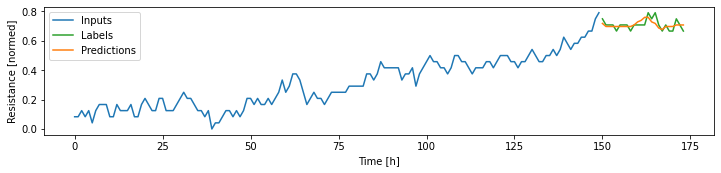

In [24]:
IPython.display.clear_output()

#multi_val_performance = model.evaluate(multi_window.val)
#multi_performance = model.evaluate(multi_window.test, verbose=0)
multi_window.plot(model)

In [25]:
test_df_test.shape()

TypeError: 'tuple' object is not callable

In [ ]:
pred = model.predict(test_df_test)